# LaboWork: Hopfield model and RBM

In this session, we aim to see many important points preparing the futur development of a RBM:
  1. The equivalence between the Hopfield model with the bipartite formulation using latent variables
  2. How this equivalence can lead to a very easy Monte Carlo dynamics
  3. Putting all these things together, designing a learning algorithme
  
  
Let start with a simple case. These are the different steps to do:
  1. Create a array of NxP patterns, as a start take P=1
  2. In a cell, for a given $\beta$ for Hopfield, derive the equivalent Hamilonian on the bipartite network
  3. Write the expression of the following probabilities:
    * $p(s_i|\vec\tau)$ and compute the average value of $s_i$ according to this distribution
    * $p(\tau_a|\vec s)$ and compute the average value of $s_i$ according to this distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
Nv=500
P=1
ξ = 2*np.random.randint(2,size=(P,Nv))-1

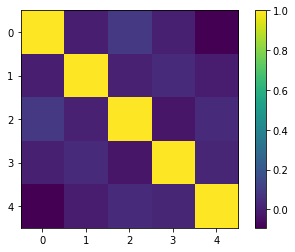

In [6]:
plt.imshow(np.matmul(ξ,ξ.T)/Nv)
plt.colorbar()

We have 
$$
\beta H = -\frac{\beta}{2N} \sum_a (\sum_i \xi_i^a s_i)^2
$$

The new Hamiltonian is then:

$$
\beta' H' = -\sqrt{\frac{\beta}{N}} \sum_{ia} \tau_a \xi_i^a s_i
$$

This gives the equivalence : $\beta' = \sqrt{\beta}$

Thanks to the bipartite structure, we find

$$
p(s_i|\vec\tau) = \frac{\exp({\sqrt{\frac{\beta}{N}} s_i \sum_a \xi_i^a \tau_a})}{\exp({\sqrt{\frac{\beta}{N}} \sum_a \xi_i^a \tau_a}) + \exp({-\sqrt{\frac{\beta}{N}}\sum_a \xi_i^a \tau_a})}
$$

hence : $\langle s_i \rangle = \tanh(\sqrt{\frac{\beta}{N}}\sum_a \xi_i^a \tau_a)$

For the other distribution we have

$$
  p(\tau_a|\vec s) \propto e^{-\tau_a^2/2} \exp(\tau_a \sqrt{\frac{\beta}{N}} \sum_i  \xi_i^a s_i)
$$

a Gaussian distribution of variance one and mean : $\langle \tau_a \rangle = \sqrt{\frac{\beta}{N}} \sum_i  \xi_i^a s_i$

The idea is to take advantage of the analytical form of the conditional distributio to sequentially generate the hidden variables starting from a visible configuration. Then to update the visible ones using the new configuration of the hidden, and so on.

Create the following two functions:
  * SampleHiddens: take a set of Nc configurations of visible nodes, the temperature $\beta$ and the patterns. It returns both the mean values and a set of Nc configurations of hidden drawn from $p(\tau_a|\vec s)$
  * SampleVisibles: take a set of Nc configurations of hidden nodes, the temperature $\beta$ and the patterns. It returns both the mean values and a set of Nc configurations of visible drawn from $p(s_i|\vec\tau)$
  
When done, make a function name MCMCSampling, that runs this loop for a t steps. Check that your function is working with one pattern - this should correspond to the Ising model with a magnetization toward one pattern.

In [8]:
# Vis : [Nv,Ns]
# ξ : [P,Nv]
# return : Hidd,M_Hidd [P,Ns]
def SampleHiddens(Vis, β, ξ):
    mean_Hidd = np.sqrt(β/Vis.shape[0]) * np.matmul(ξ,Vis)
    Hidd = np.random.normal(mean_Hidd)
    return Hidd, mean_Hidd

In [9]:
# Hidd : [P,Ns]
# ξ : [P,Nv]
# return : Vis,M_Vis [Nv,Ns]
def SampleVisibles(Hidd, β, ξ):
    mean_Vis = np.tanh(np.sqrt(β/ξ.shape[1]) * np.matmul(ξ.T,Hidd))
    Vis = (np.random.rand(ξ.shape[1],Hidd.shape[1]) < (mean_Vis+1)/2)*2 - 1
    return Vis, mean_Vis

In [10]:
Ns = 100
VisInit =  (np.random.rand(Nv,Ns) < 0.5)*2 - 1
H, MH = SampleHiddens(VisInit,0.5,ξ)
V, MV = SampleVisibles(H,0.5,ξ)

In [11]:
MH[:,:5]

array([[-0.9486833 , -0.75894664,  0.56920998,  0.37947332,  0.56920998]])

In [12]:
def Sampling(VInit,ts,β,ξ):
    V, MV = [],[]
    H, MH = SampleHiddens(VInit,β,ξ)
    for t in range(ts):
        V, MV = SampleVisibles(H,β,ξ)
        H, MH = SampleHiddens(V,β,ξ)
        
    return V,MV,H,MH

In [16]:
Nv = 1000
Ns = 400
P = 1
ξ = 2*np.random.randint(2,size=(P,Nv))-1
VisInit =  (np.random.rand(Nv,Ns) < 0.5)*2 - 1
βr = np.arange(0.1,2.5,0.1)
m = np.zeros((βr.shape[0],P))
for i in range(len(βr)):
    V,MV,H,MH = Sampling(VisInit,40,βr[i],ξ)
    # m[i] = np.mean(np.abs(np.matmul(ξ,np.mean(V,1))))
    m[i,:] = np.mean(np.abs(np.matmul(ξ,V)/Nv),1)
    # print(np.matmul(ξ,V)/Nv)

In [15]:
m1 = m*1.0

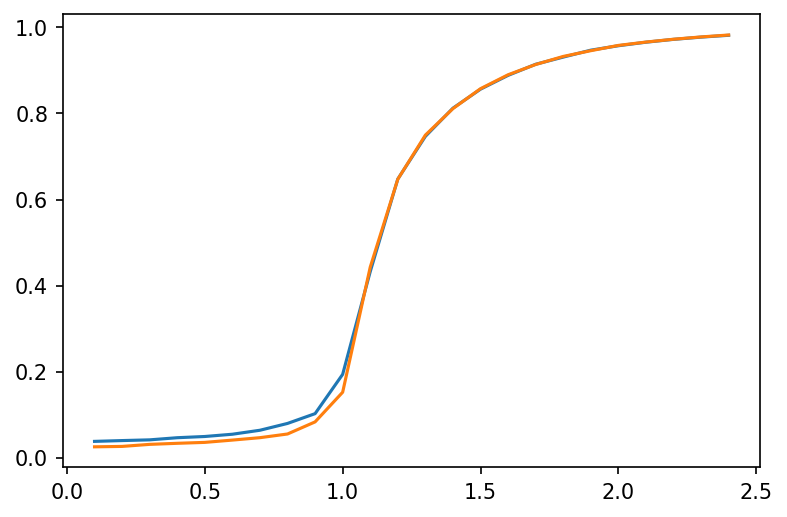

In [19]:
plt.figure(dpi=150)
plt.plot(βr,m1)
plt.plot(βr,m)

In [36]:
Nv = 500
Ns = 1
P = 3
ξ = 2*np.random.randint(2,size=(P,Nv))-1
VisInit =  (np.random.rand(Nv,Ns) < 0.5)*2 - 1
β = 1.3
print(P/Nv)
tmax = 200
m = np.zeros((tmax+1,P))
m[0,:] = np.mean(np.abs(np.matmul(ξ,VisInit)/Nv),1)
V = VisInit
for t in range(tmax):
    V,MV,H,MH = Sampling(V,500,β,ξ)    
    m[t+1,:] = np.mean(np.abs(np.matmul(ξ,V)/Nv),1)
    

0.006


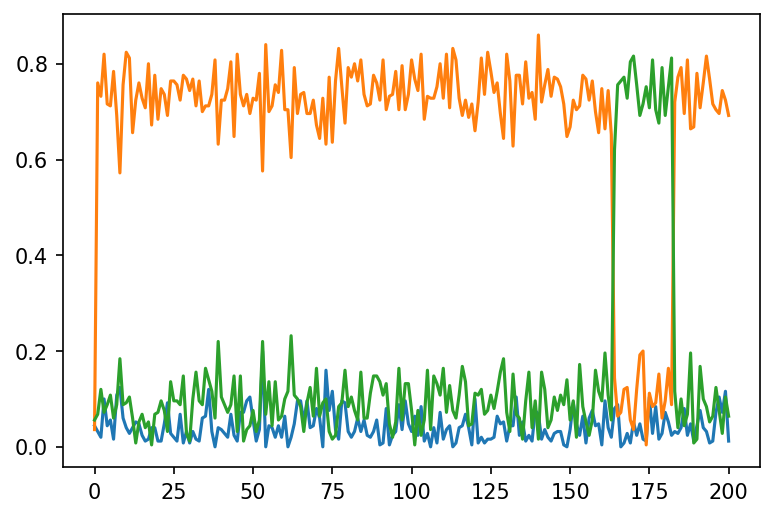

In [37]:
plt.figure(dpi=150)
plt.plot(m)